In [1]:
# !pip install watchdog

import numpy as np
import scipy.misc as misc
import pandas as pd
import re,scipy,os,json,time
import logging
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
import scipy.io
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.externals import joblib
import shutil
import imp 
util = imp.load_source('f_plot_obj', 'fotranPlot/fPlotFuntion.py') 
import f_plot_obj
print(scipy.__version__)
import time
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s : %(message)s', filename='inference.log')
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s : %(message)s')
console.setFormatter(formatter)
logging.getLogger('').addHandler(console)

global NE
global TRAINING_SET 
global PAGE
global DATASET_PATH
global RESULT_PATH
global MODEL_NAME



1.1.0


In [52]:
# n_estimators
# NE = 50
# NE = sys.argv[2]

# traning model 
# TRAINING_SET = 5000
# TRAINING_SET = sys.argv[1]

# DEFAULT
PAGE = 20

DATASET_PATH = '/home/cuda/benchuang/TONG_well_inverse_new/'
DIR_PATH_COV = '/home/cuda/benchuang/TONG_random_forest/'
# RESULT_PATH = '/home/cuda/ResultDirectory'
RESULT_PATH = '/home/cuda/benchuang/TONG_random_forest/ResultDirectory'


# rf_(traingsize)_(page)_(n_estimators)
# MODEL_NAME = 'rf_{0}_{1}_{2}'.format(TRAINING_SET, PAGE, NE)
# MODEL_PATH = '/home/cuda/benchuang/TONG_random_forest/rf_model_covariance_4000'
# MODEL_NAME = 'rf_model_covariance_4000'

MODEL_NAME = 'rf_stage3_4000'

In [33]:
def plot_stress(seqs):
        print(seqs)
#         validation_name = [e for e in validation_path.split(os.path.sep) if e is not ''][-1]
        validation_name = ['F'+str(seqs).zfill(7)][0]
        logging.info('Plot stress: {}'.format(validation_name))
        format = 0
        
        if not os.path.exists(os.path.join(RESULT_PATH, validation_name)  ):
            os.mkdir(os.path.join(RESULT_PATH, validation_name) )
            
        stress_names = ['Stress'+str(i).zfill(2)+'.JSON' for i in range(1,PAGE+1)]
        for n_index, stress_name in enumerate(stress_names):
            filepath = os.path.join(DATASET_PATH, validation_name, stress_name)        
            with open(filepath) as f:
                data = json.loads(f.read())['21*21']
                
            f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=data, format=format, x=21, y=21)
            file = [item for item in os.listdir() if 'RES' in item][0]
            os.rename(file, stress_name.replace('.JSON','.dat'))
            shutil.move(stress_name.replace('.JSON','.dat'), 
                        os.path.join(RESULT_PATH, validation_name, stress_name.replace('.JSON','.dat')))
            
            logging.debug(stress_name)


In [34]:
def prepare_dataset(dir_path, seq, pages):     
    stress = []
    coordinate = []
    for n_index, i in enumerate(pages):
#         print(dir_path, seq, i)
        filepath = os.path.join(dir_path, seq, i)        
        with open(filepath) as f:
            data = json.loads(f.read())['21*21']
        data = np.array(data).reshape([21,21])            
        for r_index, row in enumerate(data):
            for e_index, e in enumerate(row):
                coordinate.append([r_index, e_index])
                stress.append(e)
    return coordinate, stress, data

def cov_p2p(x, y, k_matrix):
    point_list = [k_matrix[y][x], k_matrix[y+1][x], k_matrix[y][x+1], k_matrix[y+1][x+1]]
    v_list = []
    for p1 in point_list:
        pv_list=[]
        for p2 in point_list:
            pv_list.append(p1*p2)
#         v_list = v_list + pv_list
        v_list.append(sum(pv_list))
    return v_list

def sequence_dataframe(dir_path, seq):
    dataframe = []
    
    PAGES = 20
    pages = range(1, PAGES+1)
    page_names = ['Stress'+str(i).zfill(2)+'.JSON' for i in pages]
    
    for y in range(20):
        for x in range(20):
            feature_list=[x, y]
            for page_name in page_names:
                _, _, data = prepare_dataset(dir_path, seq, [page_name])
                feature_list = feature_list + cov_p2p(x,y,data)

            with open(os.path.join(dir_path, seq, 'material.JSON')) as f:
                data = json.loads(f.read())['20*20']
            data = np.array(data).reshape([20,20]) 
            feature_list.append(data[y][x])

            dataframe.append(feature_list)
    return dataframe




In [42]:
# seqs=9001
# validation_name = 'F'+str(seqs).zfill(7)
# df = sequence_dataframe(DATASET_PATH, validation_name)
# val_X = df[:8]
# val_y = df[82]

In [44]:
# print(pd.DataFrame(val_X))

In [54]:
# rf = joblib.load(MODEL_NAME)

def inference(arg_list):
#     num = range(1, PAGE)
#     num = ['Stress'+str(i).zfill(2)+'.JSON' for i in num]
#     seqs = arg_list['seqs']
#     validation_name = ['F'+str(seqs).zfill(7)]  
        
    # Predict start time
    start = time.time()

#     val_X, val_y = prepare_dataset(arg_list)

    seqs=9001
    validation_name = 'F'+str(seqs).zfill(7)
    df = pd.DataFrame(sequence_dataframe(DATASET_PATH, validation_name))
    
    val_X = df[df.columns[0:82]]
    val_y = df[df.columns[82]]
    
    predicted_dataset = rf.predict(val_X)

    # Predict end time
    end = time.time()
    elapsed = end - start
    logging.info('Predict {} spends {} seconds'.format(arg_list['seqs'], round(elapsed, 2)))

    
    # Calculate the absolute errors
    errors = abs(predicted_dataset - val_y)

    # Print out the mean absolute error (mae)
#     print('Mean_Absolute_Error:', round(np.mean(errors), 2), 'degrees.')

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / val_y)

    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
#     print('Accuracy:', round(accuracy, 2), '%.')

    # Reshape array to 2-d
    image = np.array(predicted_dataset).reshape([20,20])
    val_image = np.array(val_y).reshape([20,20])
    
    creteria = dict(
        test_score = r2_score(val_y, predicted_dataset),
        spearman = list(spearmanr(val_y, predicted_dataset)),
        pearson = list(pearsonr(val_y, predicted_dataset)),
        Mean_Absolute_Error = round(np.mean(errors), 2),
        Accuracy = round(accuracy, 2)
        )
    
    logging.info(creteria)
    
    
    if not os.path.exists(os.path.join(RESULT_PATH, MODEL_NAME)):
        os.mkdir(os.path.join(RESULT_PATH, MODEL_NAME))

    # Move to directory
    DIR_NAME = os.path.join(RESULT_PATH, MODEL_NAME, validation_name)
    if not os.path.exists(DIR_NAME):
        os.mkdir(DIR_NAME)

    # output predict .dat 
    f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=predicted_dataset, format=1, x=21, y=21)
    file = [item for item in os.listdir() if 'RES' in item][0]
    os.rename(file, 'predict.dat')
    logging.debug('predict.dat write finish!')

    # output val_image .dat
    f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=val_y, format=1, x=21, y=21)
    file = [item for item in os.listdir() if 'RES' in item][0]
    os.rename(file, 'validation.dat')
    logging.debug('validation.dat write finish!')

    # output predict and val raw data .txt
    with open(os.path.join(DIR_NAME ,'valid_predict.txt'),'w') as f:
        f.write(' '.join(val_y.astype(str))+'\n')
        f.write(' '.join(predicted_dataset.astype(str))+'\n')
    logging.debug('valid_predict.txt write finish!')

    # output difference data
    diff_list = predicted_dataset-val_y
    f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=diff_list, format=1, x=21, y=21)
    file = [item for item in os.listdir() if 'RES' in item][0]
    os.rename(file, 'diff.dat')
    logging.debug('Diff write finish!')
    
    for move_file in ['predict.dat', 'validation.dat', 'diff.dat']:
        shutil.move(move_file, os.path.join(DIR_NAME, move_file))

    return image, val_image

seqs=9001
arg_list=dict(dir_path=DATASET_PATH,
              DIR_PATH_COV=DIR_PATH_COV,
              seqs=seqs,
              _num=20,
              _lags=30
             )
# plot_stress(arg_list['seqs'])
image, val_image = inference(arg_list)







[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
2018-12-31 00:55:19,681 - INFO : Predict 9001 spends 4.88 seconds
2018-12-31 00:55:19,691 - INFO : {'test_score': 0.39823759377144086, 'spearman': [0.7449188388664456, 5.902281434462019e-72], 'pearson': [0.6686061705443518, 3.7340214868608134e-53], 'Mean_Absolute_Error': 2.56, 'Accuracy': -8.5}


In [49]:
print(image.flatten()[:10])
print(val_image.flatten()[:10])

[2.39146 2.39092 2.88266 2.36408 2.3288  2.64992 4.25532 3.4971  4.16648
 6.7662 ]
[0.262 0.363 0.456 0.292 0.227 0.306 0.691 0.964 1.38  2.31 ]


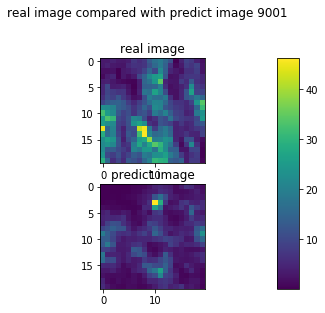

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

# print(val_image)

# plot original label image
plt.subplot(211)
plt.title('real image')
plt.imshow(image)

# plot predict image
plt.subplot(212)
plt.title('predict image')
plt.imshow(val_image)

# adjust plot location
plt.subplots_adjust(bottom=0, right=0.9, top=0.8)
cax = plt.axes([0.8, 0.0, 0.05, 0.8])
plt.colorbar(cax=cax)
plt.suptitle('real image compared with predict image {}'.format(seqs), fontsize=12)
plt.show()

